<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/Perceptron_pytorch_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch を用いたパーセプトロンの実装

## ライブラリのインポート
PyTorch を利用する場合，`torch`，ネットワーク定義と損失関数定義に用いる `torch.nn`, 最適化アルゴリズムを定義する `torch.optim` をインポートする。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## モデルの定義
パーセプトロンは１層のみの MLP とみなせるから，モデルは `Linear()` のみで構成される。

In [2]:
#  多クラス分類用単層パーセプトロン
class MultiClassPerceptron(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassPerceptron, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

    def predict(self, x):
        """予測クラスを返す"""
        with torch.no_grad():
            output = self.forward(x)
            _, predicted = torch.max(output, 1)
            return predicted

## モデルの学習

In [3]:
# モデルを学習するための関数
def train_perceptron(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.01):
    """パーセプトロンの学習"""

    # 損失関数とオプティマイザー
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # 損失・正解率の履歴を格納するためのリスト
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # 勾配降下法による学習
        model.train() # モデルを学習モードに設定

         # 勾配の初期化
        optimizer.zero_grad()

        # 順伝搬
        outputs = model(X_train)
        loss = criterion(outputs, y_train.long())

        # 逆伝搬
        loss.backward()
        optimizer.step()

        # エポックごとの損失を記録
        train_losses.append(loss.item())

        with torch.no_grad():
            # 訓練データでの精度評価
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train.long()).float().mean().item()
            train_accuracies.append(train_accuracy)

            # テストデータでの精度評価
            model.eval() # モデルを評価モードに設定
            test_outputs = model(X_test)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = (test_predicted == y_test.long()).float().mean().item()
            test_accuracies.append(test_accuracy)

        # 進捗表示
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

    return train_losses, train_accuracies, test_accuracies

## メイン関数

In [4]:
# メイン実行部分
if __name__ == "__main__":
    # デバイス設定
    # GPU が利用可能場合，GPU を利用する
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用デバイス: {device}")

    # 3クラス，２次元のデータを生成する
    # 線形分離できないよう，cluster_std を大きめにとる
    print("\nデータ，作るよ !!!")
    X, y = make_blobs(n_samples=500, centers=3, n_features=2,
                                  cluster_std=4.0, random_state=42)

    # 訓練・テスト用へのデータ分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    # 標準化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # テンソル化
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    print(f"訓練データ: {X_train.shape}, テストデータ: {X_test.shape}")

    # モデルのインスタンス化
    model = MultiClassPerceptron(input_size=2, num_classes=3).to(device)

    # モデルの学習と予測
    print("\n学習，始めるよ !!!")
    train_loss_history, train_acc_history, test_acc_history = train_perceptron(
        model, X_train_tensor, y_train_tensor.float(),
        X_test_tensor, y_test_tensor.float(),
        epochs=500, lr=0.01
    )

    print("\n最終結果:")
    print(f"訓練データに対する正解率: {train_acc_history[-1]:.4f}")
    print(f"テストデータに対する正解率: {test_acc_history[-1]:.4f}")

使用デバイス: cpu

データ，作るよ !!!
訓練データ: (350, 2), テストデータ: (150, 2)

学習，始めるよ !!!
Epoch [100/500], Loss: 0.5978, Train Acc: 0.8886, Test Acc: 0.7867
Epoch [200/500], Loss: 0.5110, Train Acc: 0.9114, Test Acc: 0.8267
Epoch [300/500], Loss: 0.4540, Train Acc: 0.9143, Test Acc: 0.8467
Epoch [400/500], Loss: 0.4141, Train Acc: 0.9171, Test Acc: 0.8467
Epoch [500/500], Loss: 0.3847, Train Acc: 0.9200, Test Acc: 0.8400

最終結果:
訓練データに対する正解率: 0.9200
テストデータに対する正解率: 0.8400


## 学習履歴の可視化


=== 学習履歴 ===


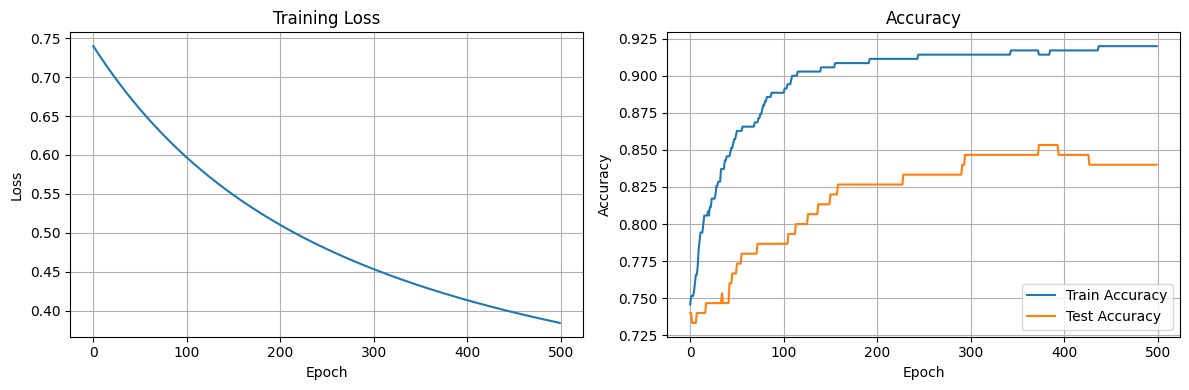

In [6]:
# 学習履歴の可視化
def plot_training_history(train_losses, train_accuracies, test_accuracies=None):
    """学習履歴をプロット"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Train Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ### ax2.plot(train_accuracies, label='Train Accuracy', marker='o', markersize=3)
    ax2.plot(train_accuracies, label='Train Accuracy')
    if test_accuracies and len(test_accuracies) > 0:
        ### ax2.plot(test_accuracies, label='Test Accuracy', marker='s', markersize=3)
        ax2.plot(test_accuracies, label='Test Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 学習履歴の可視化
print("\n=== 学習履歴 ===")
plot_training_history(train_loss_history, train_acc_history, test_acc_history)

## (参考) 決定境界の可視化

In [ ]:
# 決定境界の可視化
def plot_decision_boundary(model, X, y, title="Decision Boundary", device='cpu'):
    """決定境界を可視化（2次元データのみ）"""
    if X.shape[1] != 2:
        print("可視化は2次元データのみサポートしています")
        return

    plt.figure(figsize=(5, 4))

    # データ範囲の設定
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # 予測
    model.eval()
    with torch.no_grad():
        mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)

        Z = model.predict(mesh_points)
        Z = Z.cpu().numpy().reshape(xx.shape)

    # 等高線プロット
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # データポイントのプロット
    scatter = plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(),
                         cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# 可視化

# 決定境界の可視化
plot_decision_boundary(model, X_train_tensor, y_train_tensor.float(),
                        "Multi-class Classification - Train Data", device=device)